In [27]:
!pip install -qU langgraph langchain_community langchain_anthropic langchain_experimental

In [ ]:
import os

os.environ['ANTHROPIC_API_KEY'] = 'your-anthropic-api-key-here'
os.environ['TAVILY_API_KEY'] = 'your-tavily-api-key-here'

# Multi-Agent Supervisor

Instead of using multiple agents to solve a complicated problem, we can also create an agent group, with an agent supervisor to help delegate tasks.

# Create tools

In this section, we will make an agent to do web search with a search engine, and one agent to create plots.

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

repl = PythonREPL()

@tool
def python_repl_tool(
        code: Annotated[str, "The python code to execute to generate your chart"],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error{repr(e)}"

    result_str = f"Successfully executed:\n\```python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

## Create Agent Supervisor

It will use LLM with structured output to choose the next worker node or finish processing.

In [ ]:
from langgraph.graph import MessagesState

# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The `next` field indicates where to route to next
    next: str

In [43]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import START, END, StateGraph
from langchain_anthropic import ChatAnthropic


# team members
members = ['researcher', 'coder']
# Our team supervisor is an LLM node. It picks the next agent to process
# and decides when the work is completed
options = members + ['FINISH']

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH"""
    #next: Literal[*options] # make sure python version >= 3.11
    # otherwise
    next: Literal['researcher', 'coder', 'FINISH']


# LLM
llm = ChatAnthropic(model='claude-3-sonnet-20240229')


def supervisor_node(state: AgentState) -> AgentState:
    messages = [
        {'role': 'system', 'content': system_prompt}
    ] + state['messages']

    response = llm.with_structured_output(Router).invoke(messages)

    next_ = response['next']
    if next_ == 'FINISH':
        next_ = END

    return {'next': next_}

# Construct Graph

In [44]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier="You are a researcher. DO NOT do any math."
)

def research_node(state: AgentState) -> AgentState:
    result = research_agent.invoke(state)
    return {
        'messages': [
            HumanMessage(content=result['messages'][-1].content,
                         name='researcher')
        ]
    }

In [45]:
code_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
)


def code_node(state: AgentState) -> AgentState:
    result = code_agent.invoke(state)
    return {
        'messages': [
            HumanMessage(content=result['messages'][-1].content,
                         name='coder')
        ]
    }

In [46]:
# build graph
builder = StateGraph(AgentState)
builder.add_edge(START, 'supervisor')
builder.add_node('supervisor', supervisor_node)
builder.add_node('researcher', research_node)
builder.add_node('coder', code_node)

Connect all the edges in the graph.

In [47]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    builder.add_edge(member, 'supervisor')

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
builder.add_conditional_edges(
    'supervisor',
    lambda state: state['next']
)

graph = builder.compile()

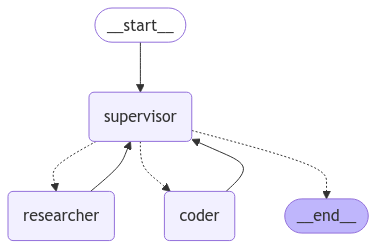

In [48]:
from IPython.display import Image, display

display(Image(
    graph.get_graph().draw_mermaid_png(),
))

# Invoke the team

In [49]:
for s in graph.stream(
    {'messages': [
        ('user', "What's the square root of 42?")
    ]},
    subgraphs=True
):
    print(s)
    print('--------')

((), {'supervisor': {'next': 'researcher'}})
--------
(('researcher:a24c4fe6-eece-126a-9459-0ae685d60750',), {'agent': {'messages': [AIMessage(content='Unfortunately I do not have the capability to calculate mathematical operations like square roots directly. As an AI assistant without access to computational tools, I cannot perform that type of calculation. However, I can provide some general information about square roots and the number 42 if that would be helpful.', additional_kwargs={}, response_metadata={'id': 'msg_01Vk8Ko6sK64AqUJMZ6FBka7', 'model': 'claude-3-sonnet-20240229', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 283, 'output_tokens': 60}}, id='run-daf6b600-db47-4125-bbee-f61c7a888988-0', usage_metadata={'input_tokens': 283, 'output_tokens': 60, 'total_tokens': 343, 'input_token_details': {}})]}})
--------
((), {'researcher': {'messages': [HumanMessage(content='Unfortunately I do not have the capability to calculate mathematical operations l

(('coder:78dc7560-89be-f4ff-de3a-8555ca7ca88d',), {'agent': {'messages': [AIMessage(content=[{'text': 'Here is how we can calculate the square root of 42 using Python:', 'type': 'text'}, {'id': 'toolu_019Y6iKbxkaVAZ5cFERsCJwL', 'input': {'code': 'import math\n\nx = 42\nsqrt_x = math.sqrt(x)\nprint(f"The square root of {x} is: {sqrt_x}")'}, 'name': 'python_repl_tool', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_019KMVm5q1SZ4LVAWkoe1JdG', 'model': 'claude-3-sonnet-20240229', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 619, 'output_tokens': 111}}, id='run-c0e5715c-f126-4d88-b723-b1117d05181a-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\n\nx = 42\nsqrt_x = math.sqrt(x)\nprint(f"The square root of {x} is: {sqrt_x}")'}, 'id': 'toolu_019Y6iKbxkaVAZ5cFERsCJwL', 'type': 'tool_call'}], usage_metadata={'input_tokens': 619, 'output_tokens': 111, 'total_tokens': 730, 'input_token_details': {}})]}})
--------


As we can see that, just like what we asked, the `researcher` cannot perform any math operations and then the `supervisor` routes this task to the `coder` and perform this task.

In [50]:
for s in graph.stream(
    {
        'messages': [
            ('user',
             "Find the latest GDP of New York and California, then calculate the average")
        ]
    },
    subgraphs=True,
):
    print(s)
    print('--------')

((), {'supervisor': {'next': 'researcher'}})
--------
(('researcher:e437431a-a483-f3a5-d54f-298f934ad12e',), {'agent': {'messages': [AIMessage(content=[{'text': 'To find the latest GDP of New York and California, we can use the Tavily search engine:', 'type': 'text'}, {'id': 'toolu_01Q3M7b2vCMNp7Xas6ErB1PJ', 'input': {'query': 'new york gdp latest'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01YFcCAmyzbNtzx4LGBNYHAs', 'model': 'claude-3-sonnet-20240229', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 288, 'output_tokens': 84}}, id='run-741c5ff0-5f7a-4176-b375-5e653257381a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'new york gdp latest'}, 'id': 'toolu_01Q3M7b2vCMNp7Xas6ErB1PJ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 288, 'output_tokens': 84, 'total_tokens': 372, 'input_token_details': {}})]}})
--------
(('researcher:e437431a-a483-f3a5-d54f-298f